Import necessary Libraries

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

Data Collection

In [2]:
def fetch_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data

# Define date range (5 years of data)
end_date = datetime.now().strftime('%Y-%m-%d')
start_date = (datetime.now() - timedelta(days=5*365)).strftime('%Y-%m-%d')
ticker = 'AAPL'

# Fetch data
stock_data = fetch_stock_data(ticker, start_date, end_date)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Data Preprocessing

In [3]:
# Use 'Close' price for prediction
closing_prices = stock_data['Close'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(closing_prices)

# Create sequences for LSTM (use 60 days to predict the next day)
sequence_length = 60
X, y = [], []

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i, 0])
    y.append(scaled_data[i, 0])

X, y = np.array(X), np.array(y)

# Reshape X for LSTM [samples, time steps, features]
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

# Split data into training (80%) and testing (20%) sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

Build LSTM Model

In [4]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=25))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Train the Model

In [5]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 69ms/step - loss: 0.0720 - val_loss: 0.0012
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 0.0066 - val_loss: 9.1711e-04
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.0036 - val_loss: 8.0802e-04
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0034 - val_loss: 5.5560e-04
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0023 - val_loss: 6.0612e-04
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0024 - val_loss: 6.2585e-04
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0024 - val_loss: 6.2510e-04
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0023 - val_loss: 0.0010
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step - loss: 0.0021 - val_loss: 5.0985e-04
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0020 - val_loss: 8.1364e-04
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0020 - val_loss: 4.9777e-04
Epoch 12/50
27/27 ━━━━━━━━━

Make Predictions

In [6]:
# Prepare test data for prediction
test_predictions = model.predict(X_test)

# Inverse transform predictions and actual values
test_predictions = scaler.inverse_transform(test_predictions)
y_test_actual = scaler.inverse_transform([y_test])

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step


Evaluate the Model

In [7]:
# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(np.mean((test_predictions - y_test_actual.T)**2))

Visualize Results

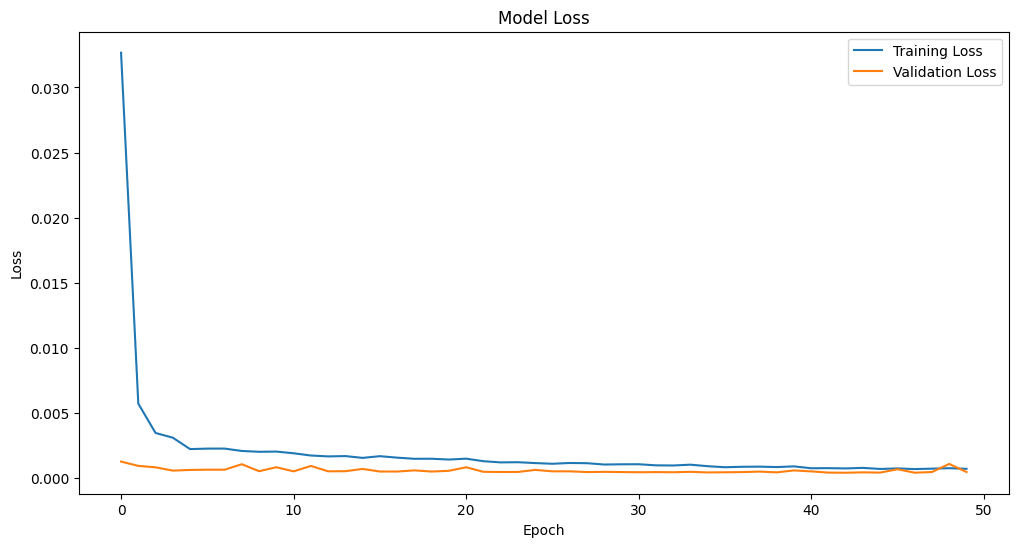

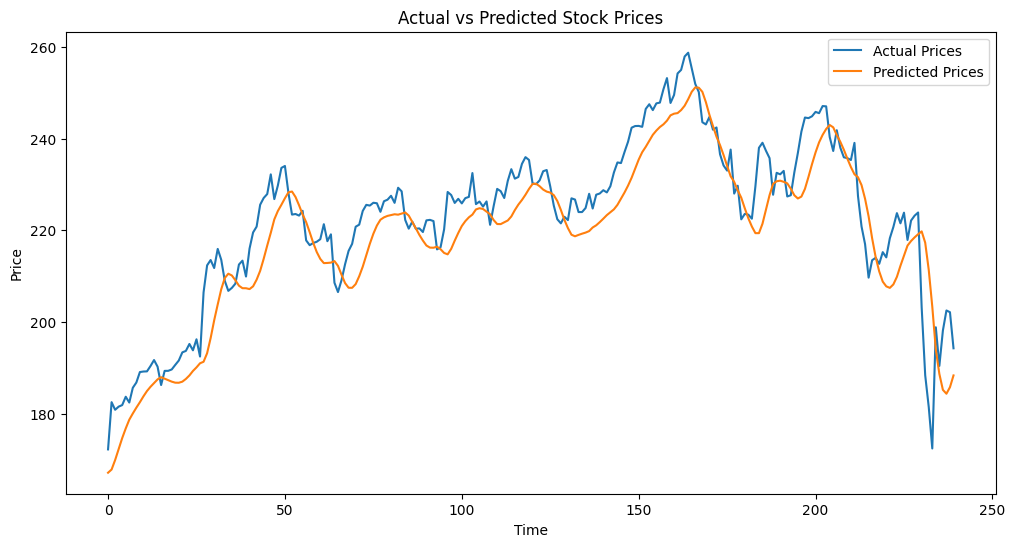

In [11]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss_plot.png')


# Plot actual vs predicted prices
plt.figure(figsize=(12, 6))
plt.plot(y_test_actual.T, label='Actual Prices')
plt.plot(test_predictions, label='Predicted Prices')
plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.savefig('prediction_plot.png')

Save Model

In [9]:
model.save('lstm_stock_model.h5')

# Print RMSE
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 7.993974248118134
